# CEOS Data Cube - WOFS Classification on Combined Data Sources
*****
**Description:** This Python notebook allows users to directly interact with a CEOS-formatted data cube to perform analyses for water management. The following steps will allow users to connect to a data cube, define the analysis location and time period (extent of latitude/longitude and dates), and then run the Australian Water Observations from Space (WOFS) algorithm. The outputs of the WOFS algorithm include static and time series pixel-level water observations for any pixel. These results provide critical information for water management that will allow users to assess water cycle dynamics, historical water extent and the risk of floods and droughts. In this notebook, Landsat 5, 7, and 8 data will be used to create the output product. Future versions may consider the addition of water quality parameters (e.g. Total Suspended Matter, Chlorophyll-A, CDOM), coastal erosion analyses and in-situ precipitation and surface temperature data.
*****

**Import necessary Data Cube libraries and dependencies.**

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import numpy as np

import datacube
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_utilities import perform_timeseries_analysis
from utils.data_cube_utilities.dc_display_map import display_map
import dc_au_colormaps

import xarray as xr

from dc_notebook_utilities import create_acq_date_gui

# supress warnings
import warnings
warnings.filterwarnings('ignore')

**First, we must connect to our data cube.** We can then query the contents of the data cube we have connected to, including both the metadata and the actual data.

In [2]:
from utils.data_cube_utilities.data_access_api import DataAccessApi
api = DataAccessApi(config="/home/localuser/.datacube.conf")
dc = api.dc

**Obtain the metadata of our cube...** Initially, we need to get the platforms and products in the cube. The rest of the metadata will be dependent on these two options. We currently only have multisensor data for our Lake Chad region, so the metadata is generated below. 

**List available products for each platform**

In [3]:
# Get available products
products_info = dc.list_products()

In [4]:
# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [5]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


In [6]:
# platforms = ['LANDSAT_5', 'LANDSAT_7']
# products = ['ls5_ledaps_lake_chad_full', 'ls7_ledaps_lake_chad_full']
platforms = ['LANDSAT_7', 'LANDSAT_8']
products = ['ls7_ledaps_ghana', 'ls8_lasrc_ghana']

**With the platform and product, we can get the rest of the metadata.** This includes the resolution of a pixel, the latitude/longitude extents, and the minimum and maximum dates available of the chosen platform/product combination.

In [7]:
from utils.data_cube_utilities.dc_load import get_overlapping_area

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

In [8]:
from utils.data_cube_utilities.dc_time import dt_to_str
print("Available Latitude Extents:", full_lat)
print("Available Longitude Extents:", full_lon)
print("Available Time Extents:", np.vectorize(dt_to_str)(min_max_dates))

Available Latitude Extents: (3.772924193304, 11.318772579912)
Available Longitude Extents: (-3.772924193304, 1.886462096652)
Available Time Extents: [['2000-01-01' '2017-12-28']
 ['2013-04-13' '2018-01-01']]


In [9]:
display_map(latitude=full_lat, longitude=full_lon)

In [10]:
start_dates = ["2000-01-01","2015-01-01"]
end_dates = ["2000-12-31", "2015-12-31"]

# Weija Reservoir, Ghana
lon_small = (-0.410, -0.330)
lat_small = (5.545, 5.620)

display_map(lat_small, lon_small)

**The entire dataset for all of the defined products and platforms are loaded below.**

They are loaded seperately and then combined over the time axis of the data. Using the full time extent, you will see that there are over 400 seperate acquisitions.

In [11]:
dc.list_products()

,name,description,label,format,platform,creation_time,instrument,lon,product_type,time,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
20,from_glc,FROM-GLC Data,None,GeoTiff,FROM-GLC,None,FROM-GLC,None,FROM-GLC,None,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"
12,ls7_collections_sr_scene,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,GeoTiff,LANDSAT_7,None,ETM,None,LEDAPS,None,None,NaN,NaN,NaN,NaN
13,ls7_ledaps_ghana,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,NetCDF,LANDSAT_7,None,ETM,None,LEDAPS,None,None,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
17,ls7_ledaps_kenya,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,NetCDF,LANDSAT_7,None,ETM,None,LEDAPS,None,None,EPSG:4326,"(-0.000269493, 0.000269493)","(0.99981903, 0.99981903)","(latitude, longitude)"
18,ls7_ledaps_senegal,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,NetCDF,LANDSAT_7,None,ETM,None,LEDAPS,None,None,EPSG:4326,"(-0.000271152, 0.00027769)","(0.813456, 0.83307)","(latitude, longitude)"
16,ls7_ledaps_sierra_leone,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,NetCDF,LANDSAT_7,None,ETM,None,LEDAPS,None,None,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
19,ls7_ledaps_tanzania,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,NetCDF,LANDSAT_7,None,ETM,None,LEDAPS,None,None,EPSG:4326,"(-0.000271277688070265, 0.000271139577954979)","(0.999929558226998, 0.999962763497961)","(latitude, longitude)"
31,ls7_ledaps_vietnam,Landsat 7 USGS Collection 1 Higher Level SR sc...,None,NetCDF,LANDSAT_7,None,ETM,None,LEDAPS,None,None,EPSG:4326,"(-0.000269494585236, 0.000269494585236)","(0.943231048326, 0.943231048326)","(latitude, longitude)"
7,ls8_collections_sr_scene,Landsat 8 USGS Collection 1 Higher Level SR sc...,None,GeoTiff,LANDSAT_8,None,OLI_TIRS,None,LaSRC,None,None,NaN,NaN,NaN,NaN


**At this point, we must access our data cube and analyze our data.** In this example, we will run the WOFS algorithm. The wofs_classify function, seen below, will return a modified dataset, where a value of 1 indicates the pixel has been classified as water by the WoFS algorithm and 0 represents the pixel is non-water. You will see that this output dataset is of the same dimensions as the input dataset. 

*****

For more information on the WOFS algorithm, refer to:

Mueller, et al. (2015) "Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia." *Remote Sensing of Environment*.

In [12]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
wofs_classifications = []
measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']

for i, (product,platform) in enumerate(zip(products, platforms)):
    start_date = start_dates[i]
    end_date = end_dates[i]
    # Query the Data Cube
    dataset_in = dc.load(platform  = platform,
                         product   = product,
                         time      = (start_date, end_date),
                         lon       = lon_small, 
                         lat       = lat_small,
                         measurements=measurements)
    if len(dataset_in.dims) == 0: # The dataset is empty.
        continue
    # WOFS classification
    clean_mask = landsat_qa_clean_mask(dataset_in, platform)
    water_class = wofs_classify(dataset_in, clean_mask=clean_mask.values)
    wofs_classifications.append(water_class.copy(deep=True))
complete_dataset = None
if len(wofs_classifications) != 0:
    complete_dataset = xr.concat(wofs_classifications, 'time')
else:
    complete_dataset = xr.Dataset()

**Execute the following code and then use the generated form to choose your desired acquisition date.** The following two code blocks are only necessary if you would like to see the water mask of a single acquisition date. 

In [13]:
acq_dates = list(water_class.time.values.astype(str))
acq_dates = list(map(lambda x:x.split("T")[0],acq_dates))
acq_date_input = create_acq_date_gui(acq_dates)

Label(value='Acquisition Date: ')

Dropdown(options=('2015-01-04', '2015-01-20', '2015-02-05', '2015-02-21', '2015-03-09', '2015-04-10', '2015-05…

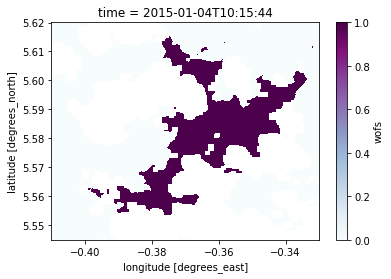

In [14]:
# Save form value
acq_date = acq_date_input.value
acq_date_index = acq_dates.index(acq_date)

# Get water class for selected acquisition date and mask no data values
water_class_for_acq_date = water_class.wofs[acq_date_index]
water_class_for_acq_date.values = water_class_for_acq_date.values.astype('float')
water_class_for_acq_date.values[water_class_for_acq_date.values == -9999] = np.nan

if len(water_class_for_acq_date.values[water_class_for_acq_date.values > -9999]) > 0:
    water_observations_for_acq_date_plot = water_class_for_acq_date.plot(cmap='BuPu')

**With all of the pixels classified as either water/non-water, let's perform a time series analysis over our derived water class.** The function, perform_timeseries_analysis, takes in a dataset of 3 dimensions (time, latitude, and longitude), then sums the values of each pixel over time. It also keeps track of the number of clear observations we have at each pixel. We can then normalize each pixel to determine areas at risk of flooding. The normalization calculation is simply:

$$normalized\_water\_observations = \dfrac{total\_water\_observations}{total\_clear\_observations}$$.

The output each of the three calculations can be seen below.

In [15]:
time_series = perform_timeseries_analysis(water_class, 'wofs')
time_series

<xarray.Dataset>
Dimensions:          (latitude: 279, longitude: 298)
Coordinates:
  * latitude         (latitude) float64 5.62 5.62 5.619 ... 5.546 5.545 5.545
  * longitude        (longitude) float64 -0.41 -0.4098 -0.4095 ... -0.3303 -0.33
Data variables:
    normalized_data  (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    min              (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    max              (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    total_data       (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    total_clean      (latitude, longitude) int64 7 7 7 7 7 7 7 ... 4 4 4 4 4 4 4

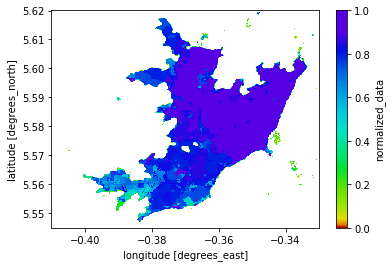

In [16]:
normalized_water_observations_plot = time_series.normalized_data.plot(cmap='dc_au_WaterSummary')

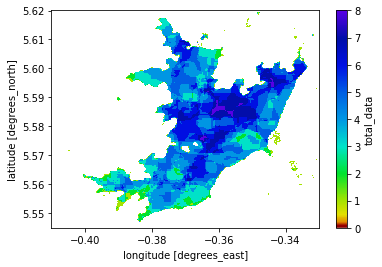

In [17]:
total_water_observations_plot = time_series.total_data.plot(cmap='dc_au_WaterObservations')

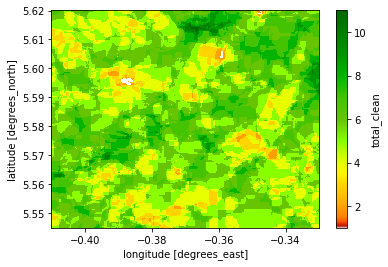

In [18]:
total_clear_observations_plot = time_series.total_clean.plot(cmap='dc_au_ClearObservations')